<ref>
https://towardsdatascience.com/using-model-interpretation-with-shap-to-understand-what-happened-in-the-titanic-1dd42ef41888


# Data Cleaning and pre-processing

Let’s start by looking at the dataset and see if any data preprocessing is required.

In [2]:
# @title SHAP installation
try:
  import shap
except:
  !pip install shap

In [9]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import random
import shap

In [21]:
df = pd.read_csv('/Users/guday/work/jupyter/Study-SHAP/Titanic_DataSET/train.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


<BR>

Let’s see if there is a significant amount of missing data:

<AxesSubplot:>

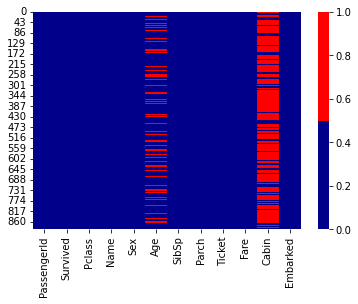

In [22]:
cols = df.columns 
colours = ['darkblue', 'red'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

It seems that the features “Age” and “Cabin” have a lot of missing values. Let’s see the percentage:

In [11]:
pct_list = []
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if round(pct_missing*100) >0:
        pct_list.append([col, round(pct_missing*100)])
    print('{} - {}%'.format(col, round(pct_missing*100)))

PassengerId - 0%
Survived - 0%
Pclass - 0%
Name - 0%
Sex - 0%
Age - 20%
SibSp - 0%
Parch - 0%
Ticket - 0%
Fare - 0%
Cabin - 77%
Embarked - 0%


In [23]:
df = df.drop(columns = ["Cabin"])

In [24]:
# extracting the title from the name:
Title = []
for name in  df.Name:
    Title.append(name.split(",")[1].split(".")[0])
    
df["Title"] = Title
#grouping people with pclass and title
df.groupby(["Pclass", 'Title'])['Age'].agg(['mean']).round(0)
# adding the mean of the age of each group to the missing values
df["Age"] = df.groupby(["Title", "Pclass"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now, I can also delete the unneeded features like the name (after extracting the title from it), the ticket ID, the passenger ID.


In [25]:
df = df.drop(columns = ["Name"])
df = df.drop(columns = ["PassengerId"])
df = df.drop(columns = ["Ticket"])

As a final step, I will encode the categorical features into numerical:

In [26]:
df.Sex = pd.Categorical(df.Sex)
df.Embarked = pd.Categorical(df.Embarked)
df["Sex"] = df.Sex.cat.codes
df["Embarked"] = df.Embarked.cat.codes

In [27]:
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,1,22.0,1,0,7.2500,2,Mr
1,1,1,0,38.0,1,0,71.2833,0,Mrs
2,1,3,0,26.0,0,0,7.9250,2,Miss


and I will drop the “Survival” outcome variable from the x-dataset

In [28]:
target = df.Survived.values
df = df.drop(columns =["Survived"])

In [31]:
df = df.drop(columns = ["Title"])

In [32]:
df.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2


# Building a Linear Model
Finally, I’m going to build the model. I will go with a simple logistic regression model since the goal here is to see how the features affect the outcome and not to obtain a high score in prediction.

In [33]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=0)
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(x_train, y_train)
LR.score(x_test, y_test)

0.8156424581005587

The model achieves an accuracy score of 82% which is reasonable for our goal.

# Model Interpretation with SHAP

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


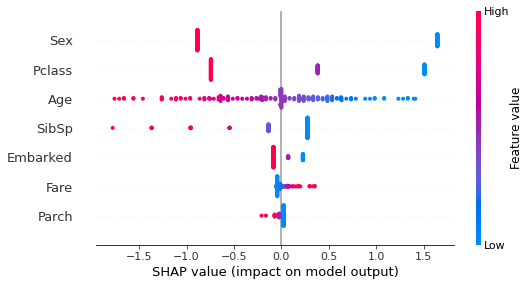

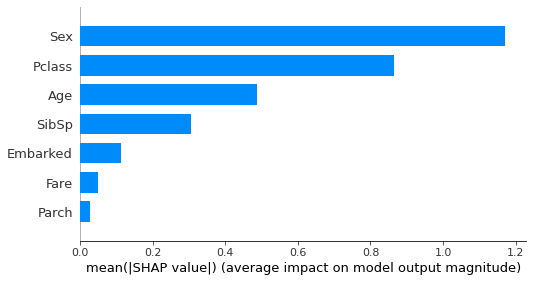

In [34]:
# import shap
explainer = shap.LinearExplainer(LR, x_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test)
shap.summary_plot(shap_values, x_train, plot_type="bar")

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


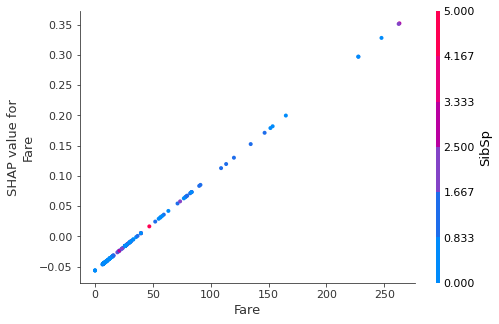

In [35]:
shap.dependence_plot("Fare", shap_values, x_test)

In [43]:
# shap.dependence_plot("Pclass", shap_values, x_test, interaction_index="Sex")

In [38]:
shap.initjs()

In [39]:
shap.force_plot(explainer.expected_value, shap_values[0,:], x_test.iloc[0,:], link="logit")

In [40]:
shap.force_plot(explainer.expected_value, shap_values[3,:], x_test.iloc[3,:], link="logit")

In [44]:
shap.force_plot(explainer.expected_value, shap_values, x_test, link="logit")